In [2]:
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(51)
np.random.seed(51)
print(tf.__version__)

2.5.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    

In [41]:
import csv
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
time_steps = []
prices = []

with open('TSLA.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    
    next(reader) #Jump the header
    
    for raw in reader:
        time_steps.append(raw[0])
        prices.append(float(raw[1]))
prices = np.array(prices)
#prices = scaler.fit_transform(prices.reshape(-1,1))

time = np.array(time_steps)
time = np.arange(len(prices))

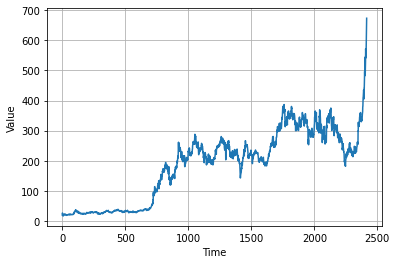

In [42]:
plot_series(time, prices)

In [43]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
        """
        window_size : Number of features (past occurences)
        batch_size : Number of sequences in a batch
        shuffle_buffer : size of the buffer
        """
        dataset = tf.data.Dataset.from_tensor_slices(series)
        dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
        dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
        dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
        dataset = dataset.batch(batch_size).prefetch(1)
        return dataset

In [44]:
split_time = 2000
time_train = time[:split_time]
x_train = prices[:split_time]
time_valid = time[split_time:]
x_valid = prices[split_time:]

window_size = 10
batch_size = 32
shuffle_buffer_size = 2000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>


# Linear Regression

In [ ]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history=model.fit(dataset,epochs=200,verbose=1)

print("Layer weights {}".format(l0.get_weights()))


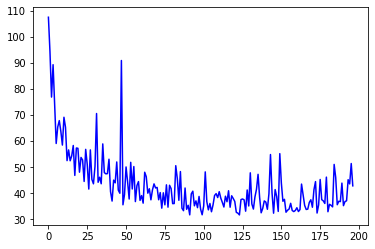

In [18]:
loss = history.history['loss'][3:]
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

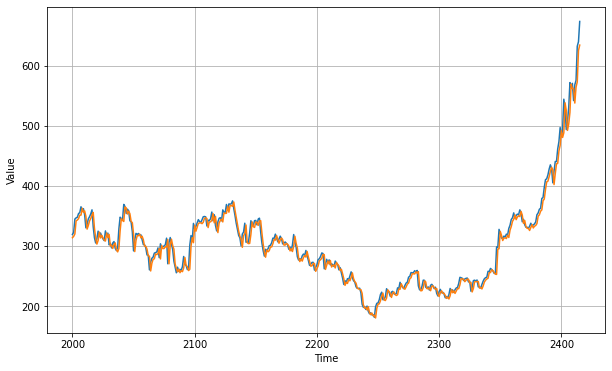

In [21]:

forecast = []

for time in range(len(prices) - window_size):
    forecast.append(model.predict(prices[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [22]:
print('MAE = {}'.format(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()))

MAE = 8.402278900146484


# **DNN**

In [50]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(30,input_shape=[window_size],activation='relu'),
                                    tf.keras.layers.Dense(30,activation='relu'),
                                    tf.keras.layers.Dense(1,activation='relu')
                                    ])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history=model.fit(dataset,epochs=200,verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
63/63 [==============================] - 0s 2ms/step - loss: 2070.7988
Epoch 2/200
63/63 [==============================] - 0s 3ms/step - loss: 89.3885
Epoch 3/200
63/63 [==============================] - 0s 3ms/step - loss: 70.1564
Epoch 4/200
63/63 [==============================] - 0s 2ms/step - loss: 63.1157
Epoch 5/200
63/63 [==============================] - 0s 2ms/step - loss: 62.1682
Epoch 6/200
63/63 [==============================] - 0s 3ms/step - loss: 55.0781
Epoch 7/200
63/63 [==============================] - 0s 2ms/step - loss: 50.2752
Epoch 8/200
63/63 [==============================] - 0s 2ms/step - loss: 64.0107
Epoch 9/200
63/63 [==============================] - 0s 3ms/step - loss: 53.3907
Epoch 10/200
63/63 [==============================] - 0s 2ms/step - loss: 44.4121
Epoch 11/200
63/63 [==============================] - 0s 2ms/step - loss: 48.1644
Epoch 12/200
63/63 [==============================] - 0s 2ms/step - loss: 46.8623
Epoch 13/200
63/63 [===

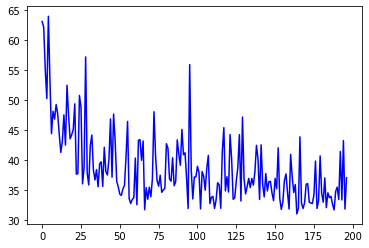

In [51]:
loss = history.history['loss'][3:]
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

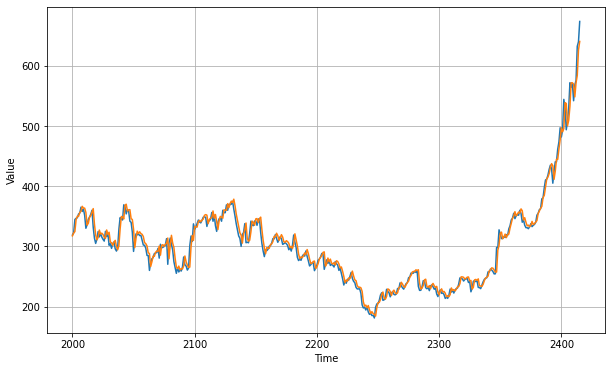

In [52]:

forecast = []

for time in range(len(prices) - window_size):
    forecast.append(model.predict(prices[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [53]:
print('MAE = {}'.format(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()))

MAE = 8.009758949279785


# **LSTM**

In [46]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=-1),input_shape=[None]),
        tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
        tf.keras.layers.LSTM(10, return_sequences=True),
        tf.keras.layers.Dense(10,activation='relu'),
        tf.keras.layers.Dense(1,activation='relu'),
        tf.keras.layers.Lambda(lambda x:x*700)

])


model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
history=model.fit(dataset,epochs=100,verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
63/63 [==============================] - 2s 5ms/step - loss: 59.5062
Epoch 2/100
63/63 [==============================] - 0s 5ms/step - loss: 45.8355
Epoch 3/100
63/63 [==============================] - 0s 5ms/step - loss: 41.5643
Epoch 4/100
63/63 [==============================] - 0s 4ms/step - loss: 38.0433
Epoch 5/100
63/63 [==============================] - 0s 5ms/step - loss: 34.5550
Epoch 6/100
63/63 [==============================] - 0s 4ms/step - loss: 31.9596
Epoch 7/100
63/63 [==============================] - 0s 5ms/step - loss: 30.5557
Epoch 8/100
63/63 [==============================] - 0s 4ms/step - loss: 29.5873
Epoch 9/100
63/63 [==============================] - 0s 5ms/step - loss: 29.2561
Epoch 10/100
63/63 [==============================] - 0s 4ms/step - loss: 29.0160
Epoch 11/100
63/63 [==============================] - 0s 5ms/step - loss: 28.6427
Epoch 12/100
63/63 [==============================] - 0s 4ms/step - loss: 28.3539
Epoch 13/100
63/63 [=====

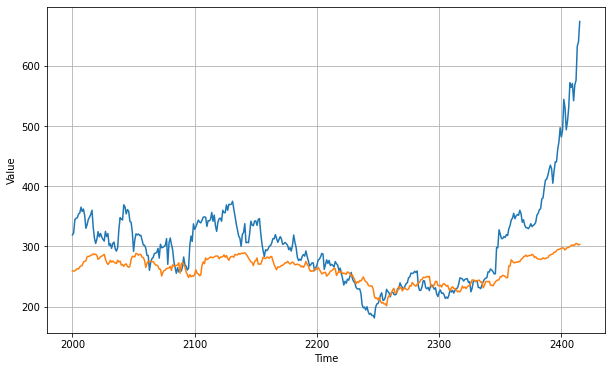

In [48]:
forecast = []

for time in range(len(prices) - window_size):
    forecast.append(model.predict(prices[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]



plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [49]:
print('MAE = {}'.format(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()))

MAE = [ 61.06092   61.192     61.042377  60.280697  59.705086  59.899284
  58.751534  58.341667  58.01615   56.553696  56.329304  56.067635
  54.801296  54.714268  54.676567  54.446342  54.393353  54.14112
  54.3093    54.213238  54.527596  55.568867  55.232906  54.78797
  54.636047  54.4638    54.25942   55.472374  56.747757  57.544548
  56.89652   55.922165  56.58187   56.147114  56.59961   56.92112
  57.179527  55.892292  56.53926   56.16199   57.867165  57.59729
  58.45788   57.55448   57.32452   58.560116  59.01666   58.306816
  55.67218   54.669426  54.767662  54.839787  54.05776   54.13244
  54.44089   54.233967  54.298885  54.931084  55.030514  55.996334
  59.087673  57.01813   56.188824  56.318752  56.20151   56.405987
  56.374016  57.048264  57.821854  57.84984   58.43358   60.018
  60.054836  64.781395  61.982388  60.881756  60.56359   59.589413
  59.48428   59.307438  58.463924  60.711887  57.6854    58.341667
  58.249233  58.07332   57.85958   56.819645  62.56639   57.4643

In [39]:
results

array([[100.25845 ],
       [101.600426],
       [103.5601  ],
       [105.60783 ],
       [107.59966 ],
       [110.333176],
       [112.56593 ],
       [114.33866 ],
       [116.21908 ],
       [117.62059 ],
       [119.08684 ],
       [119.66164 ],
       [119.72112 ],
       [118.88143 ],
       [117.332146],
       [116.682434],
       [116.778755],
       [117.16836 ],
       [117.255135],
       [117.01927 ],
       [114.84072 ],
       [112.41655 ],
       [110.5941  ],
       [109.55301 ],
       [109.38985 ],
       [108.753334],
       [108.37858 ],
       [107.61307 ],
       [107.31584 ],
       [107.13255 ],
       [107.92871 ],
       [107.62038 ],
       [107.452446],
       [106.17315 ],
       [105.4081  ],
       [104.58456 ],
       [104.320244],
       [103.97092 ],
       [103.11468 ],
       [102.93255 ],
       [103.88635 ],
       [106.52256 ],
       [109.47644 ],
       [112.038704],
       [114.03482 ],
       [116.64437 ],
       [118.42269 ],
       [119.2